In [1]:
import khmer
# ref = https://github.com/dib-lab/khmer/blob/master/examples/python-api/exact-counting.py
import tqdm
import pandas as pd
import numpy as np
import os
import scanpy.api as sc
import anndata as ad
from scipy import sparse

def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

In [2]:
dir_path = '/home/ubuntu/data/longread/'

ksize = 6
nkmers = 4**ksize
fn_lens = 0
for fn in os.listdir(dir_path):
    fn_lens = fn_lens+file_len(f'{dir_path}{fn}')
fn_lens = int(fn_lens/2)

cell_df = pd.DataFrame()
master_df = pd.DataFrame()
kmer_arr = np.zeros((nkmers, fn_lens))

arr_idx = 0
seq_id_arr = np.zeros((fn_lens), dtype = 'object')
cell_id_arr = np.zeros((fn_lens), dtype = 'object')

# ingest all .fa files from dir
for fn in os.listdir(dir_path):
    
    # extract fn prefix for cell id
    cell_id = fn.split('.fa')[0]
    
    # read .fa
    with open(f'{dir_path}{fn}', 'r') as f:
        
        # parse entry by entry
        for count, line in tqdm.tqdm(enumerate(f, start=1)):
            
            # extract first line as seq id
            if count % 2 != 0:
                k_name = line[1:-1]
                
            # extract second line as sequence
            if count % 2 == 0:
                
                # Initialize countgraph
                tablesize = nkmers + 10
                ktable = khmer.Countgraph(ksize, tablesize, 1)

                # count all k-mers in the given string
                ktable.consume(line[:-1])

                # capture full kmer counts
                k_n_list = [ktable.get(i) for i in range(nkmers)]
                
                # update kmer count arr
                kmer_arr[:,arr_idx] = k_n_list 
                
                # log sequence and cell names for metadata
                seq_id_arr[arr_idx] = k_name
                cell_id_arr[arr_idx] = cell_id
                
                # update arr pointer
                arr_idx = arr_idx + 1

# create dfs
kmers_list = [ktable.reverse_hash(i) for i in range(nkmers)]
master_df = pd.DataFrame(kmer_arr)
master_df['kmers'] = kmers_list
master_df = master_df.set_index('kmers')
master_df.columns = seq_id_arr.tolist()
cell_df = pd.DataFrame({'seq_id':seq_id_arr,
                        'cell_id':cell_id_arr,
                       })
cell_df = cell_df.set_index('seq_id')


3326it [00:01, 1994.45it/s]
11746it [00:05, 1975.91it/s]
34966it [00:17, 1967.13it/s]
9786it [00:04, 1971.35it/s]
10186it [00:05, 1979.50it/s]
7562it [00:03, 1988.08it/s]
4412it [00:02, 1976.24it/s]
3540it [00:01, 1992.82it/s]
12092it [00:06, 1967.19it/s]
6410it [00:03, 1955.78it/s]
5326it [00:02, 1950.10it/s]
6058it [00:03, 1948.87it/s]


In [3]:
# ingest data to adata obj

# pd df to np array
array_adata = master_df.values

# extract obs and var
obs = master_df.columns.tolist()
gene_names = master_df.index.tolist()

# create ad obj
adata = ad.AnnData(X=array_adata).T
adata.X = sparse.csr_matrix(adata.X)
adata.var_names = gene_names
adata.obs_names = obs

# append metadata
adata.obs['cell_id'] = cell_df.cell_id.tolist()

# transform and freeze raw state
adata.raw = sc.pp.log1p(adata, copy=True)


/home/ubuntu/anaconda3/lib/python3.7/site-packages/umap/rp_tree.py:450: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "make_euclidean_tree" failed type inference due to: Cannot unify RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none) and RandomProjectionTreeNode(none, bool, array(float32, 1d, C), float64, RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none), RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none)) for '$14.16', defined at /home/ubuntu/anaconda3/lib/python3.7/site-packages/umap/rp_tree.py (457)

File "../../anaconda3/lib/python3.7/site-packages/umap/rp_tree.py", line 457:
def make_euclidean_tree(data, indices, rng_state, leaf_size=30):
    <source elided>

        left_node = make_euclidean_tree(data, left_indices, rng_state, leaf_size)
        ^

[1] During: resolving callee type: recursive(type(CPUDispatcher(<function make_euclidean_tree at 0x7fc06

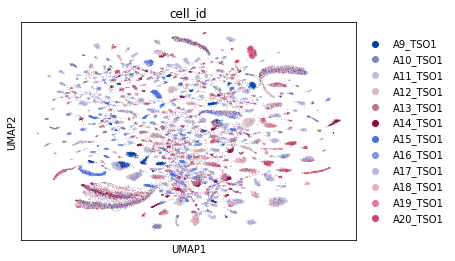

In [4]:
# embed and cluster

n_pcs = 10
n_neighbs = 30
louvain_res = 1
min_dist = 0.7

all_forms_adata = sc.pp.log1p(adata, copy=True) 
sc.pp.scale(all_forms_adata) 
sc.tl.pca(all_forms_adata, use_highly_variable = False, n_comps=n_pcs, random_state=1) 
sc.pp.neighbors(all_forms_adata, n_pcs=n_pcs, n_neighbors = n_neighbs, random_state=1) 
sc.tl.umap(all_forms_adata, min_dist = min_dist, random_state=1)
sc.tl.louvain(all_forms_adata, resolution = louvain_res, random_state=1)
sc.pl.umap(all_forms_adata, color=['cell_id'])
